# Multiverse analysis
Exponent effects are robust across a range of SpecParam hyperparameters

## Set-up

### Imports

In [25]:
# Imports - standard
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec

In [ ]:
# Imports - custom
import sys
sys.path.append(f"../code")
from paths import PROJECT_PATH
from settings import *
from paired_hierarchical_bootstrap import hierarchical_bootstrap as run_hb
from utils import get_start_time, print_time_elapsed

In [3]:
# auto reload
%load_ext autoreload
%autoreload 2

### Settings

In [4]:
N_ITERATIONS = 1000 # number of iterations for bootstrapping


In [5]:
# set plotting style
plt.style.use('../mplstyle/nature_neuro.mplstyle')

### Functions

In [6]:

def load_stats():
    # load permutatiobn results
    fname = f"{PROJECT_PATH}/data/results/band_power_statistics.csv"
    df_stats = pd.read_csv(fname, index_col=0)
    df_stats = df_stats.loc[df_stats['memory']=='hit']

    # find channels with significant alpha and gamma modulation
    df_stats['sig_all'] = df_stats['alpha_sig'] & df_stats['gamma_sig']
    df_stats['sig_any'] = df_stats['alpha_sig'] | df_stats['gamma_sig']

     #split by conditoin
    df_w = df_stats.loc[df_stats['material']=='words']
    df_f = df_stats.loc[df_stats['material']=='faces']
    
    return df_w, df_f


## Main

### load results

In [66]:
# load each and assign "run" column
path_in = f"{PROJECT_PATH}/data/specparam_sensitivity_analysis"
files = os.listdir(path_in)
results_list = []
for i_file, file in enumerate(files):
    if file.endswith(".csv"):
        df_i = pd.read_csv(f"{path_in}/{file}")
        df_i.insert(5, "run", int(file.split('_')[-1].split('.')[0]))
        results_list.append(df_i)

df = pd.concat(results_list)
df = df.reset_index(drop=True)
df

,patient,chan_idx,material,memory,epoch,run,ap_mode,peak_width_limits,max_n_peaks,peak_threshold,offset,exponent,error,r_squared,r2_adj,alpha_total_power,alpha_adjusted_power,gamma_total_power,gamma_adjusted_power,knee
0,pat02,4,faces,hit,post,0,fixed,4.0,4,3,6.260491,2.233457,0.105802,0.972167,0.969608,4.143884,-0.022919,2.167429,0.042463,NaN
1,pat04,0,faces,hit,post,0,fixed,4.0,4,3,6.166513,1.672437,0.117739,0.935843,0.932279,4.689037,-0.022919,3.128115,0.042463,NaN
2,pat04,39,faces,hit,post,0,fixed,4.0,4,3,6.316879,2.072426,0.180019,0.912903,0.908064,4.206019,-0.022919,2.479034,0.042463,NaN
3,pat04,41,faces,hit,post,0,fixed,4.0,4,3,6.362978,2.320616,0.175606,0.911407,0.909502,3.803484,-0.022919,2.022183,0.042463,NaN
4,pat04,44,faces,hit,post,0,fixed,4.0,4,3,5.618247,1.650887,0.178549,0.854219,0.851084,3.684932,-0.022919,2.555018,0.042463,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38875,pat22,44,words,miss,pre,9,knee,inf,8,3,6.844050,2.930868,0.079425,0.978812,0.978121,3.094241,-0.047246,1.446705,0.014079,4073.668055
38876,pat22,46,words,miss,pre,9,knee,inf,8,3,6.074444,2.540372,0.103708,0.967001,0.965925,3.041787,-0.047246,1.424126,0.014079,416.262894
38877,pat22,47,words,miss,pre,9,knee,inf,8,3,6.237908,2.776452,0.085534,0.983025,0.981881,3.276021,-0.047246,1.214083,0.014079,226.925719
38878,pat22,51,words,miss,pre,9,knee,inf,8,3,7.197370,3.137721,0.070230,0.988796,0.987623,3.724650,-0.047246,1.518144,0.014079,1619.859628


In [67]:
# load task-modulation results
df_w, df_f = load_stats()

for df_m in [df_w, df_f]:
    df_m.drop(columns=['alpha_pre', 'alpha_post', 'alpha_pval', 'alpha_sign', 
                     'gamma_pre', 'gamma_post', 'gamma_pval', 'gamma_sign',
                     'alpha_sig', 'gamma_sig', 'sig_any'], inplace=True)
    
df_w

,patient,material,memory,chan_idx,sig_all
18,pat02,words,hit,0,False
19,pat02,words,hit,1,False
20,pat02,words,hit,2,False
21,pat02,words,hit,3,False
22,pat02,words,hit,4,False
...,...,...,...,...,...
2722,pat22,words,hit,48,False
2723,pat22,words,hit,49,False
2724,pat22,words,hit,50,False
2725,pat22,words,hit,51,True


### example analysis 

In [68]:
# test on one

run = 0
material = 'words'
ap_mode = 'knee'

# join stats with parameters
df_0 = df.loc[(df['run']==run) & (df['material']==material) & (df['ap_mode']==ap_mode) &(df['memory']=='hit')].reset_index(drop=True)
df_merge = pd.merge(df_0, df_w, on=['patient','chan_idx','material','memory']).drop(columns=['run','material','memory'])

# get task-modulated channel results only
results = df_merge.loc[df_merge['sig_all']].reset_index(drop=True)
results


,patient,chan_idx,epoch,ap_mode,peak_width_limits,max_n_peaks,peak_threshold,offset,exponent,error,r_squared,r2_adj,alpha_total_power,alpha_adjusted_power,gamma_total_power,gamma_adjusted_power,knee,sig_all
0,pat04,0,post,knee,4.0,4,3,7.259233,2.415795,0.080623,0.979516,0.977373,4.689450,-0.074349,2.818429,0.050062,344.428199,True
1,pat04,0,pre,knee,4.0,4,3,8.239496,3.035112,0.073294,0.989862,0.988396,5.070158,-0.042758,2.657652,0.021687,2286.046502,True
2,pat04,45,post,knee,4.0,4,3,7.154387,2.384879,0.068725,0.985674,0.983603,4.688272,-0.074349,2.772532,0.050062,251.953229,True
3,pat04,45,pre,knee,4.0,4,3,8.473748,3.192337,0.072999,0.991507,0.990618,5.116263,-0.042758,2.592719,0.021687,3331.477592,True
4,pat04,49,post,knee,4.0,4,3,7.960852,3.045775,0.062537,0.990038,0.988995,4.402874,-0.074349,2.354429,0.050062,3766.484245,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203,pat22,47,pre,knee,4.0,4,3,6.478497,2.848874,0.085702,0.983129,0.981992,3.307763,-0.042758,1.260337,0.021687,520.455049,True
204,pat22,51,post,knee,4.0,4,3,6.877220,2.798449,0.079040,0.984345,0.983290,3.616409,-0.074349,1.754981,0.050062,777.943978,True
205,pat22,51,pre,knee,4.0,4,3,7.151715,3.049231,0.072805,0.988622,0.987855,3.627768,-0.042758,1.561574,0.021687,1413.076707,True
206,pat22,52,post,knee,4.0,4,3,6.353890,2.569938,0.078392,0.981991,0.980106,3.348268,-0.074349,1.667956,0.050062,430.127701,True


p-value: <0.01
True mean difference: 0.20
Condition 'pre' > 'post'


c:\Users\micha\projects\oscillation_vs_exponent\notebooks\../code\paired_hierarchical_bootstrap.py:248: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(**plotting_params, ax=ax0, palette='colorblind')
c:\Users\micha\projects\oscillation_vs_exponent\notebooks\../code\paired_hierarchical_bootstrap.py:249: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.swarmplot(**plotting_params, ax=ax0, size=2, palette='dark:#000000')


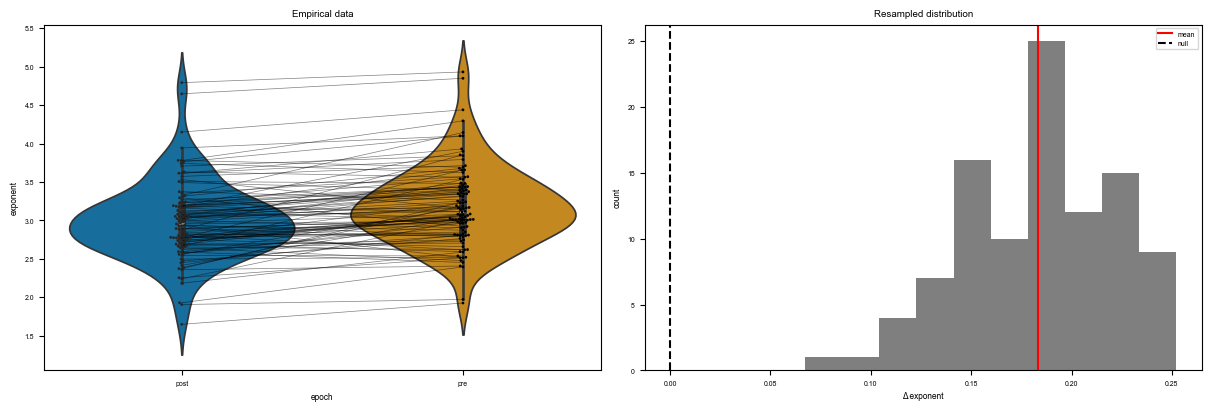

In [70]:
# apply hierarchical bootstrap 
feature = 'exponent'
 
# drop nan values
df_r = results.copy()
df_r = df_r.dropna(subset=feature)

# apply hierarchical bootstrap
hb = run_hb(df_r, feature, 'epoch', 'patient', 'chan_idx', 100)
p_value, sign, distribution, true_mean = hb


### main analysis

In [85]:
# apply for all runs
feature = 'exponent'

# time it
start_time = get_start_time()

# run
df_list = []
for i_run in range(15):
    print(f"Run {i_run}")
    start_time_i = get_start_time()
    for material, df_m in zip(['words', 'faces'], [df_w, df_f]):
        for ap_mode in ['knee', 'fixed']:
            # get task-modulated channel results only
            df_0 = df.loc[(df['run']==i_run) & (df['material']==material) & (df['ap_mode']==ap_mode) &(df['memory']=='hit')].reset_index(drop=True)
            df_merge = pd.merge(df_0, df_m, on=['patient','chan_idx','material','memory']).drop(columns=['run','material','memory'])
            results = df_merge.loc[df_merge['sig_all']].reset_index(drop=True)

            # drop nan values
            df_r = results.copy()
            df_r = df_r.dropna(subset=feature)

            # apply hierarchical bootstrap
            hb = run_hb(df_r, feature, 'epoch', 'patient', 'chan_idx', N_ITERATIONS,
                        verbose=False, plot=False)

            # create df
            df_hb = pd.DataFrame({'run': i_run, 'material': material, 
                                  'ap_mode': ap_mode, 'p_value': hb[0], 
                                  'sign': hb[1], 'true_mean': hb[3]}, index=[0])
            df_list.append(df_hb)
    
    # print time elapsed
    print_time_elapsed(start_time_i, "\tTime elapsed: ")

# join all
df_hb = pd.concat(df_list)

# print time elapsed
print_time_elapsed(start_time, "\nTotal time elapsed: ")

df_hb

Run 0
	Time elapsed: 0 hour, 6 min, and 36.0 s
Run 1
	Time elapsed: 0 hour, 5 min, and 53.0 s
Run 2
	Time elapsed: 0 hour, 7 min, and 38.0 s
Run 3
	Time elapsed: 0 hour, 11 min, and 5.0 s
Run 4
	Time elapsed: 0 hour, 5 min, and 0.0 s
Run 5
	Time elapsed: 0 hour, 4 min, and 57.0 s
Run 6
	Time elapsed: 0 hour, 4 min, and 57.0 s
Run 7
	Time elapsed: 0 hour, 4 min, and 55.0 s
Run 8
	Time elapsed: 0 hour, 4 min, and 55.0 s
Run 9
	Time elapsed: 0 hour, 4 min, and 56.0 s
Run 10
	Time elapsed: 0 hour, 4 min, and 57.0 s
Run 11
	Time elapsed: 0 hour, 5 min, and 14.0 s
Run 12
	Time elapsed: 0 hour, 5 min, and 21.0 s
Run 13
	Time elapsed: 0 hour, 9 min, and 23.0 s
Run 14
	Time elapsed: 0 hour, 14 min, and 2.0 s

Total time elapsed: 1 hour, 39 min, and 58.0 s


,run,material,ap_mode,p_value,sign,true_mean
0,0,words,knee,0.000,1,0.197370
0,0,words,fixed,0.043,1,0.109583
0,0,faces,knee,0.000,1,0.221401
0,0,faces,fixed,0.008,1,0.147400
0,1,words,knee,0.000,1,0.178897
0,1,words,fixed,0.089,1,0.094773
0,1,faces,knee,0.000,1,0.234093
0,1,faces,fixed,0.013,1,0.139653
0,2,words,knee,0.000,1,0.178457
0,2,words,fixed,0.140,1,0.090557


In [87]:
# supplement df with hyperparameters

# hyperparameter settings
hyperparameters = ['peak_width_limits', 'max_n_peaks', 'peak_threshold']
peak_width_limits = [[2, 4], [2, 8], [2, 12], [2, 16], [2, 20]]
max_n_peaks = [0, 2, 4, 6, 8]
peak_threshold = [1, 2, 3, 4, 5]

# add default hyperparameters to df
df = df_hb.copy()
df = df.assign(peak_width_limit_low = SPEC_PARAM_SETTINGS['peak_width_limits'][0],
            peak_width_limit_high = SPEC_PARAM_SETTINGS['peak_width_limits'][1],
            max_n_peaks = SPEC_PARAM_SETTINGS['max_n_peaks'],
            peak_threshold = SPEC_PARAM_SETTINGS['peak_threshold'])

# update multiverse hyperparameters
ii = 0
for jj in range(len(peak_width_limits)):
    df.loc[df['run']==ii, 'peak_width_limit_low'] = peak_width_limits[jj][0]
    df.loc[df['run']==ii, 'peak_width_limit_high'] = peak_width_limits[jj][1]
    ii += 1

for jj in range(len(max_n_peaks)):
    df.loc[df['run']==ii, 'max_n_peaks'] = max_n_peaks[jj]
    ii += 1

for jj in range(len(peak_threshold)):
    df.loc[df['run']==ii, 'peak_threshold'] = peak_threshold[jj]
    ii += 1

# reassign zero to lowest value (1/N)
df.loc[df['p_value']==0, 'p_value'] = 1/N_ITERATIONS
# df.loc[df['p_value']==0, 'p_value'] = 1/100 # TEMP - re-run with 1000 iterations - TEMP

df


,run,material,ap_mode,p_value,sign,true_mean,peak_width_limit_low,peak_width_limit_high,max_n_peaks,peak_threshold
0,0,words,knee,0.001,1,0.197370,2,4.0,4,3
0,0,words,fixed,0.043,1,0.109583,2,4.0,4,3
0,0,faces,knee,0.001,1,0.221401,2,4.0,4,3
0,0,faces,fixed,0.008,1,0.147400,2,4.0,4,3
0,1,words,knee,0.001,1,0.178897,2,8.0,4,3
0,1,words,fixed,0.089,1,0.094773,2,8.0,4,3
0,1,faces,knee,0.001,1,0.234093,2,8.0,4,3
0,1,faces,fixed,0.013,1,0.139653,2,8.0,4,3
0,2,words,knee,0.001,1,0.178457,2,12.0,4,3
0,2,words,fixed,0.140,1,0.090557,2,12.0,4,3


In [ ]:
# # # save df
# df.to_csv(f"{PROJECT_PATH}/data/results/sensitivity_analysis_hb.csv")

### plot

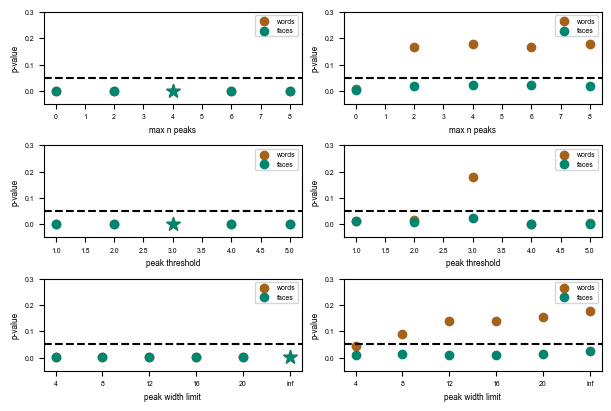

In [91]:
# plot figure 4-2

# create figure, gridspec, and subplots
fig = plt.figure(figsize=[6,4], constrained_layout=True)
spec = gridspec.GridSpec(figure=fig, ncols=2, nrows=3, width_ratios=[1,1], 
                         height_ratios=[1,1,1])
ax_00 = fig.add_subplot(spec[0,0])
ax_10 = fig.add_subplot(spec[1,0])
ax_20 = fig.add_subplot(spec[2,0])
ax_01 = fig.add_subplot(spec[0,1])
ax_11 = fig.add_subplot(spec[1,1])
ax_21 = fig.add_subplot(spec[2,1])

# plot subplots
for col, (ap_mode, axes) in enumerate(zip(['knee', 'fixed'], 
                                          [[ax_00, ax_10, ax_20], 
                                           [ax_01, ax_11, ax_21]])):
    # max n peaks
    for material in ['words', 'faces']:
        df_plt = df.loc[(df['ap_mode']==ap_mode) & \
                        (df['material']==material) & \
                        (df['max_n_peaks']!=SPEC_PARAM_SETTINGS['max_n_peaks']) & \
                        (df['peak_threshold']==SPEC_PARAM_SETTINGS['peak_threshold']) & \
                        (df['peak_width_limit_high']==SPEC_PARAM_SETTINGS['peak_width_limits'][1])]
        axes[0].scatter(df_plt['max_n_peaks'].values, df_plt['p_value'].values, 
                   label=material, color=MCOLORS[material])
        
        # plot defaults
        df_plt = df.loc[(df['ap_mode']==ap_mode) & \
                        (df['material']==material) & \
                        (df['max_n_peaks']==SPEC_PARAM_SETTINGS['max_n_peaks']) & \
                        (df['peak_threshold']==SPEC_PARAM_SETTINGS['peak_threshold']) & \
                        (df['peak_width_limit_high']==SPEC_PARAM_SETTINGS['peak_width_limits'][1])]
        if ap_mode == 'knee':
            axes[0].scatter(SPEC_PARAM_SETTINGS['max_n_peaks'], df_plt['p_value'].values[0], 
                        color=MCOLORS[material], marker='*', s=100)
        else:
            axes[0].scatter(SPEC_PARAM_SETTINGS['max_n_peaks'], 
                            df_plt['p_value'].values[0], 
                            color=MCOLORS[material])
        
    # peak threshold
    for material in ['words', 'faces']:
        df_plt = df.loc[(df['ap_mode']==ap_mode) & \
                        (df['material']==material) & \
                        (df['max_n_peaks']==SPEC_PARAM_SETTINGS['max_n_peaks']) & \
                        (df['peak_threshold']!=SPEC_PARAM_SETTINGS['peak_threshold']) & \
                        (df['peak_width_limit_high']==SPEC_PARAM_SETTINGS['peak_width_limits'][1])]
        axes[1].scatter(df_plt['peak_threshold'].values, df_plt['p_value'].values, 
                   label=material, color=MCOLORS[material])
        
        # plot defaults
        df_plt = df.loc[(df['ap_mode']==ap_mode) & \
                        (df['material']==material) & \
                        (df['max_n_peaks']==SPEC_PARAM_SETTINGS['max_n_peaks']) & \
                        (df['peak_threshold']==SPEC_PARAM_SETTINGS['peak_threshold']) & \
                        (df['peak_width_limit_high']==SPEC_PARAM_SETTINGS['peak_width_limits'][1])]
        if ap_mode == 'knee':       
            axes[1].scatter(SPEC_PARAM_SETTINGS['peak_threshold'], 
                            df_plt['p_value'].values[0], 
                            color=MCOLORS[material], marker='*', s=100)
        else:
            axes[1].scatter(SPEC_PARAM_SETTINGS['peak_threshold'], 
                            df_plt['p_value'].values[0], 
                            color=MCOLORS[material]) 
    # width limits
    for material in ['words', 'faces']:
        df_plt = df.loc[(df['ap_mode']==ap_mode) & \
                        (df['material']==material) & \
                        (df['max_n_peaks']==SPEC_PARAM_SETTINGS['max_n_peaks']) & \
                        (df['peak_threshold']==SPEC_PARAM_SETTINGS['peak_threshold']) & \
                        (df['peak_width_limit_high']!=SPEC_PARAM_SETTINGS['peak_width_limits'][1])]
        df_plt.loc[df_plt['peak_width_limit_high']==np.inf, 
                     'peak_width_limit_high'] = 24 # reassign inf to 24
        axes[2].scatter(df_plt['peak_width_limit_high'].values, df_plt['p_value'].values, 
                  label=material, color=MCOLORS[material])
        
        # plot defaults
        df_plt = df.loc[(df['ap_mode']==ap_mode) & \
                        (df['material']==material) & \
                        (df['max_n_peaks']==SPEC_PARAM_SETTINGS['max_n_peaks']) & \
                        (df['peak_threshold']==SPEC_PARAM_SETTINGS['peak_threshold']) & \
                        (df['peak_width_limit_high']==SPEC_PARAM_SETTINGS['peak_width_limits'][1])]
        df_plt.loc[df_plt['peak_width_limit_high']==np.inf, 
                    'peak_width_limit_high'] = 24 # reassign inf to 24
        if ap_mode == 'knee':
            axes[2].scatter(24, df_plt['p_value'].values[0],
                            color=MCOLORS[material], marker='*', s=100)
        else:
            axes[2].scatter(24, df_plt['p_value'].values[0], 
                            color=MCOLORS[material])

# set axis labels
for ax_i in [ax_00, ax_01]:
    ax_i.set_xlabel('max n peaks')
    ax_i.set_ylabel('p-value')

for ax_i in [ax_10, ax_11]:
    ax_i.set_xlabel('peak threshold')
    ax_i.set_ylabel('p-value')

for ax_i in [ax_20, ax_21]:
    ax_i.set_xlabel('peak width limit')
    ax_i.set_ylabel('p-value')
    ax_i.set_xticks([4, 8, 12, 16, 20, 24], 
                    labels=['4', '8', '12', '16', '20', 'inf'])

# further annotations
for ax_i in [ax_00, ax_01, ax_10, ax_11, ax_20, ax_21]:
    # set legend
    ax_i.legend(loc='upper right')

    # annotate alpha (p=0.05)
    ax_i.axhline(0.05, color='k', linestyle='--')

# set y-axis limits to match for all subplots
for ax_i in [ax_00, ax_01, ax_10, ax_11, ax_20, ax_21]:
    ax_i.set_ylim([-0.05, 0.3])




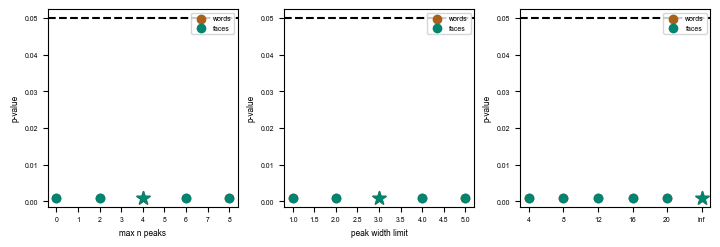

In [95]:
# plot figure 4-2

# init fig
fig, axes = plt.subplots(1, 3, figsize=[WIDTH['2col'], WIDTH['2col']/3])

# max n peaks
for material in ['words', 'faces']:
    df_plt = df.loc[(df['ap_mode']==AP_MODE) & \
                    (df['material']==material) & \
                    (df['max_n_peaks']!=SPEC_PARAM_SETTINGS['max_n_peaks']) & \
                    (df['peak_threshold']==SPEC_PARAM_SETTINGS['peak_threshold']) & \
                    (df['peak_width_limit_high']==SPEC_PARAM_SETTINGS['peak_width_limits'][1])]
    axes[0].scatter(df_plt['max_n_peaks'].values, df_plt['p_value'].values, 
                label=material, color=MCOLORS[material])
    
    # plot defaults
    df_plt = df.loc[(df['ap_mode']==AP_MODE) & \
                    (df['material']==material) & \
                    (df['max_n_peaks']==SPEC_PARAM_SETTINGS['max_n_peaks']) & \
                    (df['peak_threshold']==SPEC_PARAM_SETTINGS['peak_threshold']) & \
                    (df['peak_width_limit_high']==SPEC_PARAM_SETTINGS['peak_width_limits'][1])]
    axes[0].scatter(SPEC_PARAM_SETTINGS['max_n_peaks'], df_plt['p_value'].values[0], 
                color=MCOLORS[material], marker='*', s=100)
    
# peak threshold
for material in ['words', 'faces']:
    df_plt = df.loc[(df['ap_mode']==AP_MODE) & \
                    (df['material']==material) & \
                    (df['max_n_peaks']==SPEC_PARAM_SETTINGS['max_n_peaks']) & \
                    (df['peak_threshold']!=SPEC_PARAM_SETTINGS['peak_threshold']) & \
                    (df['peak_width_limit_high']==SPEC_PARAM_SETTINGS['peak_width_limits'][1])]
    axes[1].scatter(df_plt['peak_threshold'].values, df_plt['p_value'].values, 
                label=material, color=MCOLORS[material])
    
    # plot defaults
    df_plt = df.loc[(df['ap_mode']==AP_MODE) & \
                    (df['material']==material) & \
                    (df['max_n_peaks']==SPEC_PARAM_SETTINGS['max_n_peaks']) & \
                    (df['peak_threshold']==SPEC_PARAM_SETTINGS['peak_threshold']) & \
                    (df['peak_width_limit_high']==SPEC_PARAM_SETTINGS['peak_width_limits'][1])]
    axes[1].scatter(SPEC_PARAM_SETTINGS['peak_threshold'], df_plt['p_value'].values[0], 
                color=MCOLORS[material], marker='*', s=100)

# width limits
for material in ['words', 'faces']:
    df_plt = df.loc[(df['ap_mode']==AP_MODE) & \
                    (df['material']==material) & \
                    (df['max_n_peaks']==SPEC_PARAM_SETTINGS['max_n_peaks']) & \
                    (df['peak_threshold']==SPEC_PARAM_SETTINGS['peak_threshold']) & \
                    (df['peak_width_limit_high']!=SPEC_PARAM_SETTINGS['peak_width_limits'][1])]
    df_plt.loc[df_plt['peak_width_limit_high']==np.inf, 
                    'peak_width_limit_high'] = 24 # reassign inf to 24
    axes[2].scatter(df_plt['peak_width_limit_high'].values, df_plt['p_value'].values, 
                label=material, color=MCOLORS[material])
    
    # plot defaults
    df_plt = df.loc[(df['ap_mode']==AP_MODE) & \
                    (df['material']==material) & \
                    (df['max_n_peaks']==SPEC_PARAM_SETTINGS['max_n_peaks']) & \
                    (df['peak_threshold']==SPEC_PARAM_SETTINGS['peak_threshold']) & \
                    (df['peak_width_limit_high']==SPEC_PARAM_SETTINGS['peak_width_limits'][1])]
    df_plt.loc[df_plt['peak_width_limit_high']==np.inf, 
                'peak_width_limit_high'] = 24 # reassign inf to 24
    axes[2].scatter(24, df_plt['p_value'].values[0],
                color=MCOLORS[material], marker='*', s=100)

# set axis labels
for ax_i in axes:
    ax_i.set_ylabel('p-value')
axes[0].set_xlabel('max n peaks')
axes[1].set_xlabel('peak threshold')
axes[1].set_xlabel('peak width limit')
axes[2].set_xticks([4, 8, 12, 16, 20, 24], 
                labels=['4', '8', '12', '16', '20', 'inf'])

# further annotations
for ax_i in axes:
    # set legend
    ax_i.legend(loc='upper right')

    # annotate alpha (p=0.05)
    ax_i.axhline(0.05, color='k', linestyle='--')

# # set y-axis limits to match for all subplots
# for ax_i in [ax_00, ax_01, ax_10, ax_11, ax_20, ax_21]:
#     ax_i.set_ylim([-0.05, 0.3])

# # save
# fname = f"{PROJECT_PATH}/figures/main_figures/figure_4-2"
# plt.savefig(fname)
# plt.savefig(f"{fname}.png")

